# Notations

$(0,T]$:  The observation interval during which neuron spiking activity were recorded

$N_{0,t}^i$: Sample path of spike times from the recorded i-th neuron in $(0,t]$, for $t \in (0,T]$, $i \in \{1,...,n\}$

$K$: divide $(0,T]$ into $K$ intervals with width $\Delta = \frac{T}{K}$ such that there is at most one spike per interval

$k\Delta$: The point at which the latent process model is evaluated, for $k = 1,...,K$

$y^i_k = \Delta N_k^i$: The number of spikes at time k for i-th neuron.

$H_K^i = \{\Delta y_{1}^i,...,\Delta y_{K}^i\}$: history of spiking activity in $(0,K]$ for i-th neuron

$\pi_{c_i=c}$: probability of the i-th neuron belongs to cluster c

## Define the 1-dimensional state space model

$$\left\{
\begin{array}{ll}
      x_k^i = x_{k-1}^i + \epsilon_k^i, \epsilon_k \sim N(0,\sigma^2_{\epsilon i}) & (a) \\
      \lambda_k^i(k\Delta)\Delta = \frac{e^{x_k^i}}{1+e^{x_k^i}} & (b)\\
      y_{k}^i | x_k^i \sim Bernoulli(\lambda_k^i(k\Delta)\Delta) & (c)
\end{array} 
\right. $$

\begin{align*}
E[\log p(y, x, c)|y, \theta^{(l-1)}] &= E[\sum_{i=1}^n \log p(y^i, x^i|c_i;\theta_i) \pi_{c_i} |y,\theta^{(l-1)}]\\
&= \sum_{i=1}^n \{E[\log p(x^i|c_i;\sigma^2_{\epsilon c_i})|y^i;\theta^{(l-1)}]] + E[\log \pi_{c_i}|y^i;\theta^{(l-1)}] + E[\log p(y^i|x^i)|y^i;\theta^{(l-1)}]\}
\end{align*}

### 1.
\begin{align*}
\sum_{i=1}^n E[\log p(x^i|c_i;\sigma^2_{\epsilon i})|y^i;\theta^{(l-1)}]] &= \sum_{i=1}^n \sum_{c} (-\frac{K}{2} \log \sigma_{\epsilon c_i}^2 -\frac{1}{2\sigma_{\epsilon c_i}^2} \sum_{k=1}^K E[(x_k-x_{k-1})^2|c_i,y^i,\theta^{(l-1)}]) * p(c_i=c|y^i,\theta^{(l-1)})\\
\end{align*}

###  $p(c_i=c|y^i)=\frac{p(y^i|c_i=c)p(c_i=c)}{\sum_{c} p(y^i|c_i=c)p(c_i=c)}$

trick: normalize $exp(\log p(y^i|c_i=c) - \max (\log p(y^i|c_i \in \{clusters\})))$

### $\sigma_{c}^2 = \frac{\sum_{i=1}^n \sum_k (W_{i,k}+W_{i,k-1}-2W_{i,k,k-1})p(c_i=c|y^i,\sigma^{(l-1)})}{K \sum_{i=1}^n p(c_i=c|y^i,\sigma^{(l-1)})}$

where $E\{x_k || H_k, \theta^{(l)}\}$, $W_k = E\{x_k^2 || H_k, \theta^{(l)}\}$ and $W_{k,k+1}=E\{x_k x_{k-1} || H_k, \theta^{(l)}\}$


### 2. $E[\log \pi_{c_i}|y^i;\theta^{(l-1)}] = \sum_{c} \log \pi_{c_i=c} * p(c_i=c|y^i,\theta^{(l-1)})$

### $\pi_{c} = \frac{\sum_{i=1}^n p(c_i=c|y^i,\sigma^{(l-1)})}{ \sum_{c} \sum_{i=1}^n p(c_i=c|y^i,\sigma^{(l-1)})}$

$\sum_{c} \pi_{c_i = c} = 1$

Langrange multiplier: $\sum_{c} \log \pi_{c_i=c} * p(c_i=c|y^i,\theta^{(l-1)}) + \lambda (\sum_{c} \pi_{c_i = c} -1)$

take derivative: $\sum_{i=1}^n p(c_i=c|y^i,\theta^{(l-1)}) = -\lambda \pi_{c_i = c} $

sum over c: $\sum_c \sum_{i=1}^n p(c_i=c|y^i,\theta^{(l-1)}) = -\lambda$

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import sys
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
sys.path.insert(1,'./code')
from visualize import plot_raw_data, get_population_data, plot_results
from EM import TransformToProb, RunEM
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import pyparticleest.utils.kalman as kalman
from scipy.stats import bernoulli

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
class StdNonLin(nlg.NonlinearGaussianInitialGaussian):
    # x_{k+1} = x_k  + v_k = f(x_k) + v_k,
    # y_k = 0 + e_k = g(x_k) + e_k,
    # x(0) ~ N(0,P0), v_k ~ N(0,Q), e_k ~ Binom(50,\exp(x_{k})/(1+\exp(x_{k})))

    def __init__(self, P0, Q):
    # Set covariances in the constructor since they
    # are constant
        super(StdNonLin, self).__init__(Px0=P0, Q=Q)

    def calc_g(self, particles, t):
    # Calculate value of g(\xi_t,t)
         return np.zeros([len(particles),1])
    
    def calc_f(self, particles, u, t):
    # Calculate value of f(xi_t,t)
        return particles
    
    def measure(self, particles, y, t):
        """
        Return the log-pdf value of the measurement
        Args:
         - particles  (array-like): Model specific representation
           of all particles, with first dimension = N (number of particles)
         - y (array-like):  measurement
         - t (float): time-stamp
        Returns:
         (array-like) with first dimension = N, logp(y|x^i)
        """
        N = len(particles)
        trial = 50
        yrep = np.repeat(np.asarray(y), N, 0)
        coefficient = scipy.special.binom(trial, yrep)
        #lpy = scipy.stats.binom.logpmf(yrep,50,np.exp(particles[:,0])/(1.0 + np.exp(particles[:,0])),loc=0)
        lpy = np.log(coefficient) + yrep * particles[:,0] - trial * np.log(1 + np.exp(particles[:,0]))
        return lpy

In [38]:
def resample(weights):
  n = len(weights)
  indices = []
  C = [0.] + [sum(weights[:i+1]) for i in range(n)]
  u0, j = random(), 0
  for u in [(u0+i)/n for i in range(n)]:
    while u > C[j]:
      j+=1
    indices.append(j-1)
  return indices

In [27]:
def measure(X, Y, trial, t):
    coefficient = scipy.special.binom(trial,Y)
    # log-pdf of p(y_t|x_t)
    return np.log(coefficient[t]) + X[t,:] * Y[t] - trial * np.log(1+np.exp(X[t,:]))

In [28]:
def filtering(T, N, Q, trial, Y):
    ##Initialization
    t = 0
    X = np.empty([T,N])
    ancestor = np.empty([T,N])
    w = np.empty([T,N])
    W = np.empty([T,N])
    X[t,:] = np.random.normal(0, np.sqrt(Q), N)
    w[t,:] = measure(X, Y, trial, t)
    W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
    W[t,:] /= np.sum(W[t,:])
    ancestor[t,:]= X[t,resample(W[t,:])]
    for tt in range(T-1):
        t=tt+1
        a = ancestor[tt,:]
        X[t,:] = a + np.random.normal(0, np.sqrt(Q), N) ##f(x_t|x_{t-1}) standard deviation
        w[t,:] = measure(X, Y, trial, t) ##g(y_t|x_t)
        W[t,:] = np.exp(w[t,:] - np.max(w[t,:]))
        W[t,:] /= np.sum(W[t,:])
        ancestor[t,:]= X[t,resample(W[t,:])]
    
    return X, w, W, ancestor

In [50]:
def smoothing(T, N, Q, trial, M, X, W):
    w_back = np.empty([T,N])
    W_BACK = np.empty([T,N])
    smoother = np.empty([T,M])
    multinomialsamples = np.random.multinomial(M, W[T-1,:])
    ancestor_nonzero = ancestor[T-1, multinomialsamples>0]
    smoother[T-1,:] = np.repeat(ancestor_nonzero, multinomialsamples[multinomialsamples>0])
    for tt in range(T-1):
        t = T-2 - tt
        for j in range(M):
            w_back = W[t,:] * np.exp(kalman.lognormpdf_scalar(smoother[t+1,j]-X[t,:], Q))
            W_BACK[t,:] = w_back/np.sum(w_back)
            myList = np.random.multinomial(1, W_BACK[t,:])
            smoother[t,j] = X[t, next((i for i, x in enumerate(myList) if x), None)]
            
    return smoother

In [30]:
def lognormpdf_scalar(err, S):
    """
    Calculate gaussian probability density of all elements in err, when
    err[i] ~ N(0,S) and each element in err is a scalar
    """
    return -0.5 * (l2pi + np.log(S) + (err.ravel() ** 2) / S)

In [17]:
# Forward particles
N = 1000
# Backward trajectories
M = 100
# trials
trial = 50
# cluster
cluster = 2
#iterations
iteration = 20
#
sigma_ls = np.empty([iteration,cluster])
pi_ls = np.empty([iteration,cluster])
#
#
square2pi = np.sqrt(2 * np.pi)
#
l2pi = np.log(2 * np.pi)

In [18]:
mat = np.loadtxt('train_data.txt')
Y = mat[:,1:]
T = Y.shape[1]
n = Y.shape[0]

In [19]:
print Y.shape

(20, 3000)


In [20]:
pi=[0.5, 0.5]

In [21]:
sigma = [0.09354658, 0.53066518]

In [36]:
#for j in range(n):
#    posterior_of_indicator(cluster, pi, Y[j,:], sigma, N, T, trial)

# HERE IS THE ALGORITHM!

In [22]:
#%%time
sigmatmp = np.zeros([cluster,n])
loglikelihood = np.empty([cluster,n])
posterior_indicator = np.empty([cluster,n])
for i in range(iteration):
    for j in range(n):
        for c in range(cluster):
            P0 = sigma[c] * np.eye(1)
            Q = sigma[c] * np.eye(1)
            model = StdNonLin(P0, Q)
            sim = simulator.Simulator(model,u=None,y=Y[j,:])
            sim.simulate(N, M, filter='PF', smoother='ancestor', meas_first=False)
            (est_filt, w_filt) = sim.get_filtered_estimates()
            est_smooth = sim.get_smoothed_estimates()
            #[X, w, W, ancestor] = filtering(T, N, Q, trial, Y[j,:])
            #est_smooth = smoothing(T, N, Q, trial, M, est_filt[:,:,0], w_filt)
            w_unnormalized = scipy.stats.binom.logpmf(np.reshape(np.repeat(Y[j,:],N),[T,N]), trial, np.exp(est_filt[1:,:,0])/(1.0 + np.exp(est_filt[1:,:,0])), loc=0)
            #w_unnormalized = w
            maxlogweight = np.max(w_unnormalized,axis=1)
            weight = np.exp(w_unnormalized - np.reshape(np.repeat(maxlogweight, N),(T, N)))
            loglikelihood[c,j] = np.sum(np.log(np.sum(weight, axis = 1)/N)) + np.sum(maxlogweight)
            posteriorcovariance = np.array(np.diff(est_smooth[:,:,0],axis=0))**2
            #posteriorcovariance = np.array(np.diff(est_smooth,axis=0))**2
            sigmatmp[c,j] = np.sum(posteriorcovariance/(M*T))

    #maxloglikelihood = np.max(loglikelihood, axis=0)
    #w = np.exp(loglikelihood - maxloglikelihood)
    #likelihood= np.sum(np.log(np.sum(w*np.reshape(np.repeat(pi,20),(2,20)), axis=0))) + np.sum(maxloglikelihood)
    #print likelihood
    posterior_indicator = np.exp(loglikelihood - np.max(loglikelihood, axis=0)) * np.reshape(np.repeat(pi,20),(cluster,20))
    posterior_indicator = posterior_indicator/np.sum(posterior_indicator, axis=0)
    pi = np.sum(posterior_indicator,axis=1)/np.sum(posterior_indicator)
    sigma = np.sum(sigmatmp * posterior_indicator, axis=1)/np.sum(posterior_indicator,axis=1)
    sigma_ls[i,:]=sigma
    pi_ls[i,:]=pi

In [16]:
posterior_indicator

array([[  1.00000000e+000,   1.00000000e+000,   1.00000000e+000,
          1.00000000e+000,   1.00000000e+000,   1.00000000e+000,
          1.00000000e+000,   1.00000000e+000,   1.00000000e+000,
          1.00000000e+000,   0.00000000e+000,   1.53825155e-112,
          1.83280696e-152,   3.08559644e-314,   7.30649849e-131,
          5.10397162e-137,   9.04333059e-264,   4.93571717e-072,
          5.07308470e-174,   1.18623598e-170],
       [  1.01962049e-100,   1.28339225e-102,   9.87409399e-106,
          2.43564703e-072,   2.26901766e-096,   6.67195818e-102,
          2.84744280e-074,   7.68469221e-101,   2.39466884e-084,
          1.11672270e-079,   2.60232764e-076,   4.98144545e-073,
          2.21919683e-052,   1.18095571e-116,   8.66067774e-064,
          1.78978116e-090,   7.56817222e-099,   6.95440214e-063,
          1.09231116e-075,   7.71536093e-084],
       [  4.72577861e-080,   6.52237282e-073,   4.62919663e-084,
          3.41973569e-040,   1.19295822e-077,   1.82758880e-0

In [15]:
sigma_ls

array([[ 0.10030428,  0.3077158 ,  0.68197631,  0.83726327],
       [ 0.1005359 ,  0.30738706,  0.664068  ,  0.79092859],
       [ 0.10052795,  0.31045131,  0.64269539,  0.74605188],
       [ 0.09959736,  0.31603768,  0.62612042,  0.72062106],
       [ 0.09890864,  0.32085609,  0.62024778,  0.69382481],
       [ 0.09862288,  0.33591099,  0.6001435 ,  0.67019768],
       [ 0.09845061,  0.33012076,  0.59364549,  0.65484016],
       [ 0.09866227,  0.33656065,  0.56121587,  0.6470678 ],
       [ 0.0983715 ,  0.33907537,  0.55528597,  0.62779445],
       [ 0.09884338,  0.34207616,  0.54033928,  0.62280193],
       [ 0.09859378,  0.34468311,  0.54207306,  0.60703792],
       [ 0.09787379,  0.3513251 ,  0.52264475,  0.59582774],
       [ 0.09660866,  0.36187135,  0.49155387,  0.58701472],
       [ 0.09754491,  0.3475692 ,  0.49211524,  0.57852422],
       [ 0.09757411,  0.34108702,  0.48212531,  0.57607821],
       [ 0.09688031,  0.34382894,  0.47370344,  0.56551516],
       [ 0.09618946,  0.

In [ ]:
array([[ 0.09966018,  0.83753384],
       [ 0.09947227,  0.79065639],
       [ 0.09853979,  0.75890545],
       [ 0.09753917,  0.7255194 ],
       [ 0.09698717,  0.70083715],
       [ 0.09715258,  0.67592663],
       [ 0.09599162,  0.65549329],
       [ 0.09515703,  0.63925444],
       [ 0.09490611,  0.62185047],
       [ 0.09417887,  0.60438006],
       [ 0.09343204,  0.60163655],
       [ 0.09221624,  0.5925726 ],
       [ 0.09316658,  0.5796338 ],
       [ 0.09301189,  0.56344373],
       [ 0.0933514 ,  0.55695132],
       [ 0.09337476,  0.54891762],
       [ 0.09422464,  0.54206639],
       [ 0.09365101,  0.54217296],
       [ 0.09330665,  0.53464087],
       [ 0.09354658,  0.53066518]])

In [23]:
sigma_ls

array([[ 0.09377002,  0.53625399],
       [ 0.09366348,  0.53046431],
       [ 0.0929089 ,  0.52544266],
       [ 0.09324733,  0.52010903],
       [ 0.09448403,  0.51730811],
       [ 0.09368139,  0.51919176],
       [ 0.09366586,  0.51643193],
       [ 0.09385587,  0.51144436],
       [ 0.09377575,  0.50801328],
       [ 0.09452919,  0.50444353],
       [ 0.09450155,  0.50391614],
       [ 0.09484096,  0.50279359],
       [ 0.09407876,  0.49692263],
       [ 0.09353765,  0.49740399],
       [ 0.09442286,  0.4978201 ],
       [ 0.09410442,  0.49805448],
       [ 0.09373724,  0.49961169],
       [ 0.09369805,  0.5031979 ],
       [ 0.09356195,  0.4985406 ],
       [ 0.09432879,  0.50214261]])

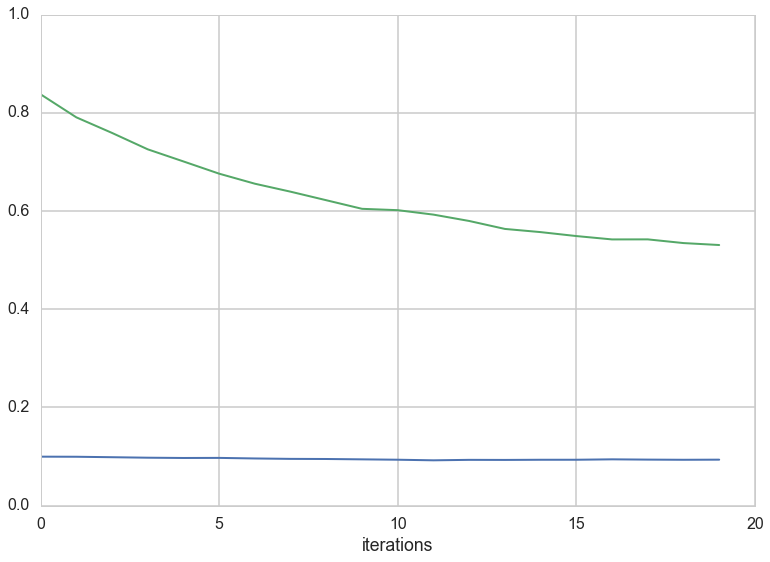

In [62]:
plt.plot(sigma_ls, '-',linewidth=2.0)
plt.ylim([0,1])
plt.xlabel('iterations')
plt.legend(loc='best')

In [ ]:
sigma= [0.57, 0.1]
pi = [0.5,0.5]
for j in range(n):
    for c in range(cluster):
        P0 = sigma[c] * np.eye(1)
        Q = sigma[c] * np.eye(1)
        model = StdNonLin(P0, Q)
        sim = simulator.Simulator(model,u=None,y=Y[j,:])
        sim.simulate(N, M, filter='PF', smoother='ancestor', meas_first=False)
        (est_filt, w_filt) = sim.get_filtered_estimates()
        est_smooth = sim.get_smoothed_estimates()
        w_unnormalized = scipy.stats.binom.pmf(np.reshape(np.repeat(Y[j,:],N),[T,N]), trial, np.exp(est_filt[1:,:,0])/(1.0 + np.exp(est_filt[1:,:,0])), loc=0)
        loglikelihood[c,j] = np.sum(np.log(np.sum(w_unnormalized, axis = 1)/N))
        posteriorcovariance = np.array(np.diff(est_smooth[:,:,0],axis=0))**2
        sigmatmp[c,j] = np.sum(posteriorcovariance/(M*T))


maxloglikelihood = np.max(loglikelihood, axis=0)
w = np.exp(loglikelihood - maxloglikelihood)
likelihood= np.sum(np.log(w*0.5)) + np.sum(maxloglikelihood)
print likelihood

posterior_indicator = np.exp(loglikelihood - np.max(loglikelihood, axis=0)) * np.reshape(np.repeat(pi,20),(2,20))
posterior_indicator = posterior_indicator/np.sum(posterior_indicator, axis=0)
pi = np.sum(posterior_indicator,axis=1)/np.sum(posterior_indicator)
sigma = np.sum(sigmatmp * posterior_indicator, axis=1)/np.sum(posterior_indicator,axis=1)
sigma_ls[i,:]=sigma
pi_ls[i,:]=pi

In [16]:
maxloglikelihood = np.max(loglikelihood, axis = 0)
np.sum(np.log(np.sum(np.exp(loglikelihood) * 0.5, axis = 0)))

-inf

In [26]:
loglikelihood

array([[-4071.37982375, -3258.84925241, -4169.09029622, -3057.66906805,
        -4809.16957752, -4324.89416938, -3874.56122365, -3299.3547864 ,
        -3176.79557216, -3949.77279062, -3900.22851337, -3475.83319616,
        -3005.01476101, -4572.53056269, -4557.56809391, -4214.83814507,
        -5359.46552555, -2838.54005387, -3306.13367036, -3891.74790745],
       [-4150.28610541, -3373.79200789, -4319.10625423, -3107.08876501,
        -4923.92638979, -4425.67586817, -3956.54471669, -3406.513156  ,
        -3250.89488508, -3994.89919102, -2392.94116515, -3092.69843601,
        -2496.76508403, -3684.79416583, -4253.09666417, -3933.34594867,
        -4522.83126965, -2612.83446662, -2844.83206355, -3157.8071494 ]])

In [25]:
np.sum([-2265.28306566, -3091.8651383 ,
        -2517.13003784, -3616.37601527, -4208.12582513, -3923.73889052,
        -4332.27453163, -2596.17670433, -2789.24345077, -3058.35288798,
       -4084.59767986, -3258.23985371, -4190.50931695, -3048.54776998,
        -4802.3827942 , -4310.8708402 , -3882.66323928, -3291.74518962,
        -3157.01094239, -3947.18237833])

-70372.316551950003

In [ ]:
pi_ls

In [23]:
sigma_ls

array([[ 0.28014961,  0.54222914],
       [ 0.35473518,  0.53960916],
       [ 0.37350976,  0.5377967 ],
       [ 0.37838432,  0.54656895],
       [ 0.36759229,  0.55947283],
       [ 0.36560106,  0.56625224],
       [ 0.36897392,  0.58025648],
       [ 0.35994039,  0.5793937 ],
       [ 0.36327151,  0.60607937],
       [ 0.34105136,  0.61790691],
       [ 0.32470374,  0.63889326],
       [ 0.32090505,  0.63220001],
       [ 0.32442454,  0.64150314],
       [ 0.32280294,  0.64681534],
       [ 0.30972575,  0.65286749],
       [ 0.29618135,  0.66731526],
       [ 0.28641572,  0.67004223],
       [ 0.27524019,  0.68762924],
       [ 0.27136235,  0.68722799],
       [ 0.28477836,  0.68276386],
       [ 0.25859325,  0.68147943],
       [ 0.2492117 ,  0.67496184],
       [ 0.22989937,  0.64680454],
       [ 0.24504767,  0.62194591],
       [ 0.24377468,  0.60261114],
       [ 0.23522021,  0.60387688],
       [ 0.22713348,  0.60638442],
       [ 0.25584743,  0.6083086 ],
       [ 0.26224676,

In [12]:
posterior_indicator

array([[  1.09348265e-050,   3.49900673e-047,   1.05352549e-064,
          2.94772274e-024,   5.72566370e-054,   1.15612277e-056,
          8.16211034e-035,   8.35179395e-055,   2.34868370e-044,
          1.94181049e-036,   1.00000000e+000,   1.00000000e+000,
          1.00000000e+000,   1.00000000e+000,   1.00000000e+000,
          1.00000000e+000,   1.00000000e+000,   1.00000000e+000,
          1.00000000e+000,   1.00000000e+000],
       [  1.00000000e+000,   1.00000000e+000,   1.00000000e+000,
          1.00000000e+000,   1.00000000e+000,   1.00000000e+000,
          1.00000000e+000,   1.00000000e+000,   1.00000000e+000,
          1.00000000e+000,   0.00000000e+000,   4.17083591e-156,
          2.58158170e-174,   1.79928827e-319,   4.31527260e-145,
          7.20142757e-127,   0.00000000e+000,   1.14700986e-083,
          1.86871555e-204,   1.49654702e-312]])

In [34]:
pickle.dump(bbb, open('/Users/zyzrdfz/Desktop/gwungwun/name_of_pickle.p','wb'))

In [ ]:
kkk = pickle.load(open('/Users/zyzrdfz/Desktop/gwungwun/name_of_pickle.p','rb'))
print kkk

## plot sigma_ls when pi is fixed as [0.5,0.5]

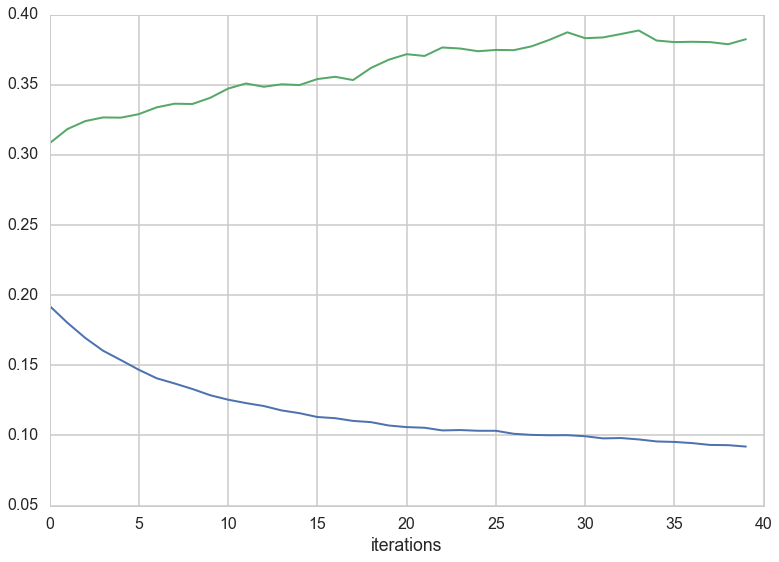

In [30]:
plt.plot(bbb, '-',linewidth=2.0)
plt.xlabel('iterations')
plt.legend(loc='best')

## sigma_ls & pi_ls change simultaneously

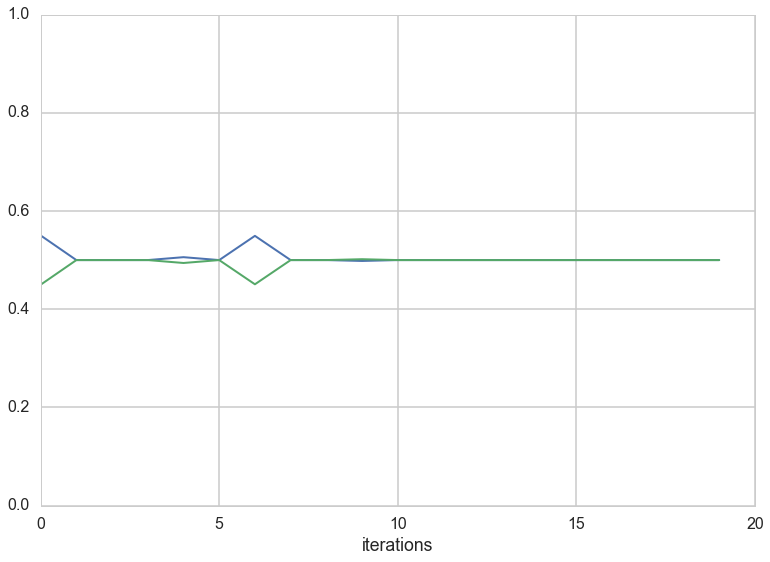

In [44]:
plt.plot(pi_ls, '-',linewidth=2.0)
plt.ylim([0,1])
plt.xlabel('iterations')
plt.legend(loc='best')

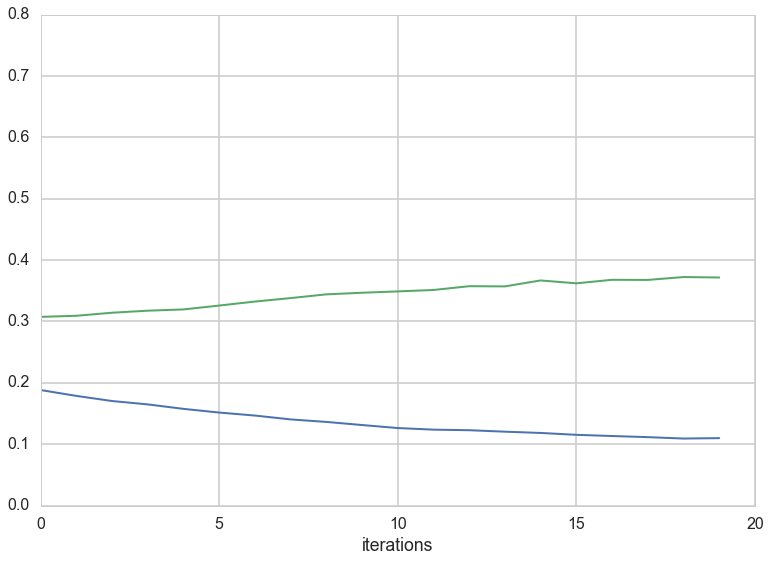

In [47]:
plt.plot(sigma_ls, '-',linewidth=2.0)
plt.ylim([0,0.8])
plt.xlabel('iterations')
plt.legend(loc='best')

## THE FOLLOWINGS ARE TEST CODES 

In [90]:
sigma = np.empty([2,1])
sigma_1_ls = np.arange(0.01, 0.61, 0.05)
sigma_2_ls = np.arange(0.01, 0.61, 0.05)
likelihood = np.zeros([len(sigma_1_ls),len(sigma_2_ls)])
loglikelihood = np.empty([cluster, n])
for i in range(len(sigma_1_ls)):
    sigma[0] = sigma_1_ls[i]
    for k in range(len(sigma_2_ls) -(len(sigma_2_ls) - i)):
        sigma[1] = sigma_2_ls[k]
        for j in range(n):
            for c in range(cluster):
                P0 = sigma[c] * np.eye(1)
                Q = sigma[c] * np.eye(1)
                model = StdNonLin(P0, Q)
                sim = simulator.Simulator(model,u=None,y=Y[j,:])
                sim.simulate(N, M, filter='PF', smoother='ancestor', meas_first=False)
                (est_filt, w_filt) = sim.get_filtered_estimates()
                w_unnormalized = scipy.stats.binom.pmf(np.reshape(np.repeat(Y[j,:],N),[T,N]), trial, np.exp(est_filt[1:,:,0])/(1.0 + np.exp(est_filt[1:,:,0])), loc=0)
                loglikelihood[c,j] = np.sum(np.log(np.sum(w_unnormalized, axis = 1)/N))
        maxloglikelihood = np.max(loglikelihood, axis=0)
        w = np.exp(loglikelihood - maxloglikelihood)
        #posterior_indicator = np.exp(loglikelihood - np.max(loglikelihood, axis=0)) * np.reshape(np.repeat(pi,20),(2,20))
        #posterior_indicator = posterior_indicator/np.sum(posterior_indicator, axis=0)
        #likelihood[i,k] = np.sum(loglikelihood * posterior_indicator)
        likelihood[i,k] = np.sum(np.log(np.sum(w)*0.5), axis = 0) + np.sum(maxloglikelihood) 

In [88]:
lll[]

array([[-104644.36601284,  -80110.01424684,  -75717.18328375,
         -73297.49703844,  -72589.38444833,  -72137.77710106,
         -72044.34861124,  -72007.92436246,  -72180.19639833,
         -72000.31207288,  -71938.07581137,  -71904.20586065],
       [ -80110.01424684,  -80251.38081653,  -75826.9294985 ,
         -73448.17491347,  -72591.39006253,  -72147.8837074 ,
         -71723.46888697,  -71550.86096094,  -71168.16704973,
         -71062.48716192,  -70828.55418925,       0.        ],
       [ -75717.18328375,  -75826.9294985 ,  -75189.9527785 ,
         -73270.28701204,  -72298.64612927,  -71763.26993795,
         -71152.94252961,  -71039.65001637,  -71114.89053715,
         -70562.83740386,       0.        ,       0.        ],
       [ -73297.49703844,  -73448.17491347,  -73270.28701204,
         -73152.63208376,  -72513.34509013,  -71428.3633505 ,
         -71417.46802246,  -70953.73538738,  -70620.51219993,
              0.        ,       0.        ,       0.        ],
    

In [86]:
aa=lll
for i in range(len(sigma_1_ls)):
    for j in range(len(sigma_1_ls)-i):
        aa[i,j]=lll[i,j]

print aa

[[-104644.36601284  -80110.01424684  -75717.18328375  -73297.49703844
   -72589.38444833  -72137.77710106  -72044.34861124  -72007.92436246
   -72180.19639833  -72000.31207288  -71938.07581137  -71904.20586065]
 [ -80110.01424684  -80251.38081653  -75826.9294985   -73448.17491347
   -72591.39006253  -72147.8837074   -71723.46888697  -71550.86096094
   -71168.16704973  -71062.48716192  -70828.55418925       0.        ]
 [ -75717.18328375  -75826.9294985   -75189.9527785   -73270.28701204
   -72298.64612927  -71763.26993795  -71152.94252961  -71039.65001637
   -71114.89053715  -70562.83740386       0.               0.        ]
 [ -73297.49703844  -73448.17491347  -73270.28701204  -73152.63208376
   -72513.34509013  -71428.3633505   -71417.46802246  -70953.73538738
   -70620.51219993       0.               0.               0.        ]
 [ -72589.38444833  -72591.39006253  -72298.64612927  -72513.34509013
   -72316.70076973  -71936.21809424  -71775.90753664  -71381.34828867
        0.      

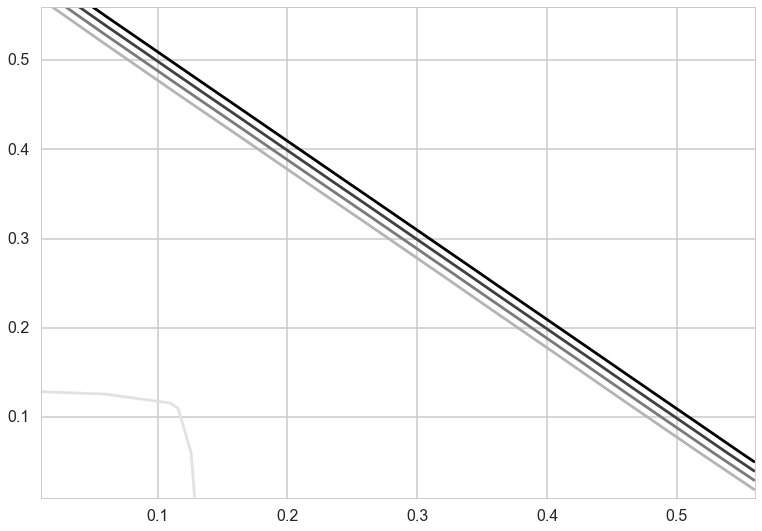

In [83]:
plt.contour(sigma_1_ls, sigma_2_ls, aa)

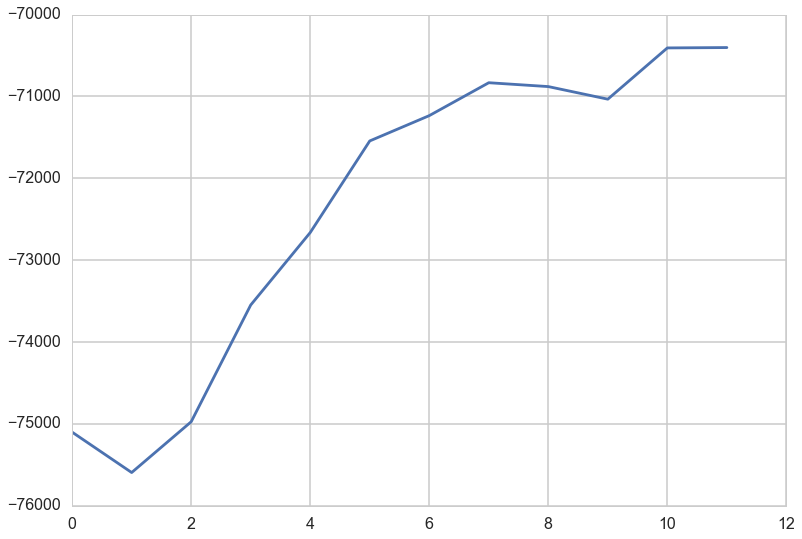

In [47]:
plt.plot(likelihood[2])

In [61]:
np.max(sigma_ls, axis=1)

array([ 0.79235562,  0.74967464,  0.6966313 ,  0.67726613,  0.65162837,
        0.6316576 ,  0.59717783,  0.57161846,  0.5617394 ,  0.54448033,
        0.52601644,  0.50723859,  0.49854422,  0.48750892,  0.48389912,
        0.47526642,  0.4669459 ,  0.4562075 ,  0.44642304,  0.44069967,
        0.434485  ,  0.42626962,  0.41776114,  0.4137815 ,  0.4133691 ,
        0.4109939 ,  0.41378331,  0.41475718,  0.4099588 ,  0.54525956])

In [17]:
sigma_ls

array([[  7.07960140e-001,   8.59188572e-001],
       [  7.10719096e-001,   8.59475913e-001],
       [  7.13481848e-001,   8.69145125e-001],
       [  7.13319245e-001,   8.79130649e-001],
       [  6.99208119e-001,   8.78696070e-001],
       [  7.19842642e-001,   8.52654375e-001],
       [  7.23370229e-001,   8.45025472e-001],
       [  7.18877413e-001,   8.61204214e-001],
       [  7.18081401e-001,   8.73125521e-001],
       [  7.07229504e-001,   8.70520288e-001],
       [  7.17359164e-001,   8.53707834e-001],
       [  7.12710853e-001,   8.53541669e-001],
       [  2.37151510e-322,   1.08221785e-312],
       [  0.00000000e+000,   2.66795449e-322],
       [  1.20958716e-312,   0.00000000e+000],
       [  2.96439388e-322,   1.33685735e-312],
       [  0.00000000e+000,   3.26083326e-322],
       [  1.46417710e-312,   2.20411637e-314],
       [  3.55727265e-322,   1.59181405e-312],
       [  0.00000000e+000,   2.00000012e+000]])

In [18]:
pi_ls

array([[ 0.74737257,  0.25262743],
       [ 0.75971493,  0.24028507],
       [ 0.80001586,  0.19998414],
       [ 0.79999999,  0.20000001],
       [ 0.67139587,  0.32860413],
       [ 0.94382841,  0.05617159],
       [ 0.81603826,  0.18396174],
       [ 0.79999071,  0.20000929],
       [ 0.83770903,  0.16229097],
       [ 0.69926991,  0.30073009],
       [ 0.8010205 ,  0.1989795 ],
       [ 0.73124484,  0.26875516],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

In [19]:
i

12

In [20]:
posterior_indicator

array([[  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.12139011e-24,   9.77332989e-01,
          7.99945585e-16,   1.00000000e+00,   7.28097685e-01,
          1.04592584e-10,   8.42315025e-26,   9.99818187e-01,
          9.19647944e-01,   3.03655485e-11],
       [  2.99698197e-23,   3.67838197e-17,   1.30641907e-17,
          1.65368158e-18,   1.29324669e-22,   7.79878317e-15,
          3.29770694e-12,   7.62214605e-20,   9.86696068e-13,
          5.03914463e-17,   1.00000000e+00,   2.26670110e-02,
          1.00000000e+00,   1.60434773e-11,   2.71902315e-01,
          1.00000000e+00,   1.00000000e+00,   1.81813485e-04,
          8.03520556e-02,   1.00000000e+00]])

In [ ]:
def posterior_of_indicator(cluster, pi, Y, sigma, N, T, trial):
    posterior_indicator = np.empty(cluster)
    loglikelihood = np.empty(cluster)
    w_unnormalized = []
    for c in range(cluster):
        P0 = sigma[c] * np.eye(1)
        Q = sigma[c] * np.eye(1)
        model = StdNonLin(P0, Q)
        sim = simulator.Simulator(model,u=None,y=Y)
        sim.simulate(N, M, filter='PF', smoother='full', meas_first=False)
        (est_filt, w_filt) = sim.get_filtered_estimates()
        w_unnormalized = scipy.stats.binom.pmf(np.reshape(np.repeat(Y,N),[T,N]), trial, np.exp(est_filt[1:,:,0])/(1.0 + np.exp(est_filt[1:,:,0])), loc=0)
        loglikelihood[c] = np.sum(np.log(np.sum(w_unnormalized, axis = 1)/N))
        #posterior_of_indicator[i] = np.exp(loglikelihood[i])*pi[i]/np.sum(np.exp(loglikelihood[i])*pi[i])
        posterior_indicator[c] = np.exp(loglikelihood[i] + np.log(pi[i]) - np.log(np.sum(np.exp(loglikelihood[i])*pi[i])))
    return posterior_indicator

In [ ]:
%%time
sigmatmp = np.zeros([cluster,n])
loglikelihood = np.empty([cluster,n])
posterior_indicator = np.empty([cluster,n])
#posterior_joint = np.empty([cluster, n])
for j in range(n):
    for c in range(cluster):
        P0 = sigma[c] * np.eye(1)
        Q = sigma[c] * np.eye(1)
        model = StdNonLin(P0, Q)
        sim = simulator.Simulator(model,u=None,y=Y[j,:])
        sim.simulate(N, M, filter='PF', smoother='full', meas_first=False)
        (est_filt, w_filt) = sim.get_filtered_estimates()
        est_smooth = sim.get_smoothed_estimates()
        w_unnormalized = scipy.stats.binom.pmf(np.reshape(np.repeat(Y[j,:],N),[T,N]), trial, np.exp(est_filt[1:,:,0])/(1.0 + np.exp(est_filt[1:,:,0])), loc=0)
        loglikelihood[c,j] = np.sum(np.log(np.sum(w_unnormalized, axis = 1)/N))
        #posterior_of_indicator[i] = np.exp(loglikelihood[i])*pi[i]/np.sum(np.exp(loglikelihood[i])*pi[i])
        #posterior_indicator[c] = np.exp(loglikelihood[c] + np.log(pi[c]) - np.log(np.sum(np.exp(loglikelihood[c])*pi[c])))
        #posterior_joint[c,j] = np.exp(loglikelihood[c]) * pi[c]
        posteriorcovariance = np.array(np.diff(est_smooth[:,:,0],axis=0))**2
        sigmatmp[c,j] = np.sum(posteriorcovariance/(M*T))

for j in range(n):
    for c in range(cluster):
        posterior_indicator[c,j]=np.exp(loglikelihood[c,j] - np.max(loglikelihood[:,j])) * pi[c] / np.dot(np.exp(loglikelihood[:,j] - np.max(loglikelihood[:,j])), pi)

for c in range(cluster):
    sigma[c] = np.dot(sigmatmp[c,:],posterior_indicator[c,:])/np.sum(posterior_indicator[c,:])
    pi[c] = np.sum(posterior_indicator[c,:])/np.sum(posterior_indicator)

In [75]:
P0 = sigma[0] * np.eye(1)
Q = sigma[0] * np.eye(1)
model = StdNonLin(P0, Q)
sim = simulator.Simulator(model,u=None,y=Y[0,:])
sim.simulate(N, M, filter='PF', smoother='ancestor', meas_first=False)
(est_filt, w_filt) = sim.get_filtered_estimates()
est_smooth = sim.get_smoothed_estimates()
w_unnormalized = scipy.stats.binom.pmf(np.reshape(np.repeat(Y[0,:],N),[T,N]), trial, np.exp(est_filt[1:,:,0])/(1.0 + np.exp(est_filt[1:,:,0])), loc=0)
loglikelihood[c,j] = np.sum(np.log(np.sum(w_unnormalized, axis = 1)/N))
posteriorcovariance = np.array(np.diff(est_smooth[:,:,0],axis=0))**2
sigmatmp = np.sum(posteriorcovariance/(M*T))

In [76]:
sigmatmp

0.19128461492363608

array([[ 0.48821698]])